# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [14]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Create Model and Load Trained Weights

In [15]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [9]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


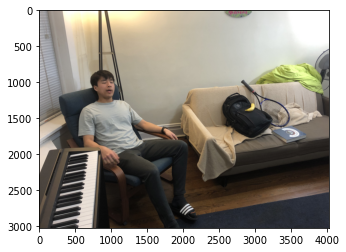

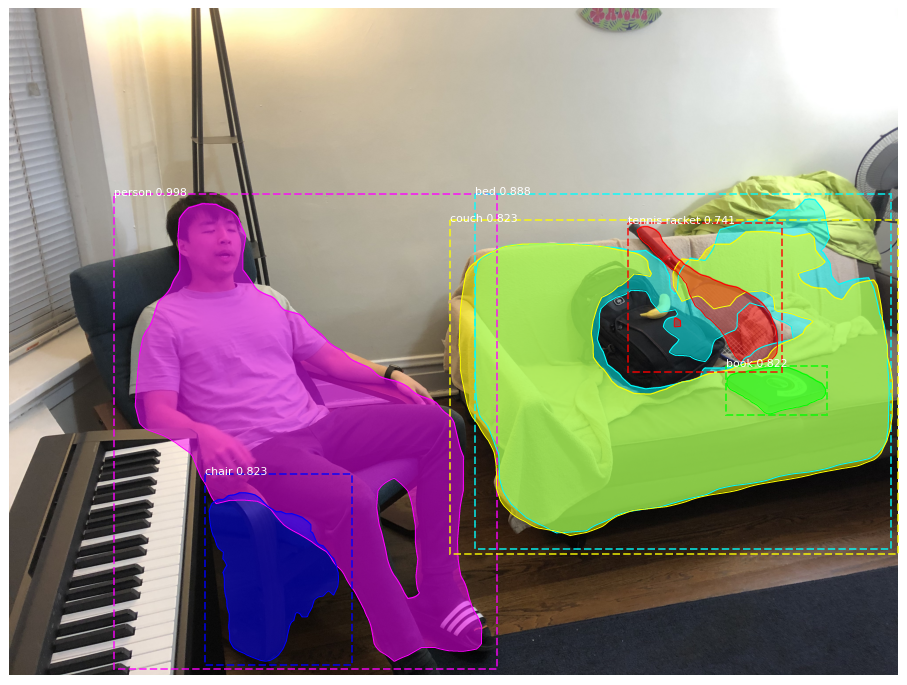

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

def MaskImage(path):
    image = skimage.io.imread(path)
    
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    fig,ax = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

im = Image.open('IMG_7246.jpg')
plt.imshow(im)

MaskImage('IMG_7246.jpg')



In [13]:
import cv2 
import scipy
import numpy as np
import glob
 
# Program To Mask a video 
def MaskVideo(path, colors): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path)  
    # Used as counter variable 
    count = 0
    # checks whether frames were extracted 
    success = 1
    
    while success: 
        if count % 10==0:
            print(count)
            
        # segment video into jpg's
        # save to images directory
        success, image = vidObj.read()
        filename = 'images/frame' + str(count) + '.jpg'
        cv2.imwrite(filename, image) 
        count += 1
    
        image = skimage.io.imread(filename)

        # Run detection
        results = model.detect([image], verbose=1)
        
        # Visualize results
        r = results[0]
        fig,ax = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], colors=colors)
        filename = 'seg_images/frame' + str(count) + '.jpg'

        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, bbox_inches=extent)
    
    # patch together masked framse and save video as 'MaskedVideo.mp4'
    img_array = []
    for i in range(1, 82):
        filename = 'seg_images/frame' + str(i) + '.jpg'
        img = cv2.imread(filename)
        img = img[0+y:870-y, 0+x:892-x]
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter('MaskedVideo.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

colors = [(0.0, 0.44444444444444464, 1.0), (0.7407407407407409, 1.0, 0.0), (0.8888888888888884, 0.0, 1.0), (0.0, 0.0, 1.0), (1.0, 0.0, 0.7407407407407405), (0.44444444444444464, 1.0, 0.0), (0.0, 1.0, 0.14814814814814792), (0.14814814814814792, 0.0, 1.0), (1.0, 0.5185185185185185, 0.0), (0.0740740740740744, 0.0, 1.0), (1.0, 0.0, 0.5925925925925926), (0.0, 0.14814814814814836, 1.0), (1.0, 0.2962962962962963, 0.0), (0.0, 1.0, 0.5925925925925926), (0.0, 0.07407407407407396, 1.0), (1.0, 0.37037037037037035, 0.0), (1.0, 0.2222222222222222, 0.0), (0.22222222222222232, 0.0, 1.0), (0.8888888888888888, 1.0, 0.0), (1.0, 0.0, 0.0740740740740744), (1.0, 0.6666666666666666, 0.0), (0.0, 0.5925925925925926, 1.0), (0.0, 1.0, 0.2962962962962963), (0.8148148148148149, 0.0, 1.0), (1.0, 0.0, 0.8148148148148149), (1.0, 0.0, 0.518518518518519), (0.666666666666667, 0.0, 1.0), (1.0, 0.0, 0.9629629629629637), (0.5925925925925926, 1.0, 0.0), (0.0, 1.0, 0.9629629629629628), (1.0, 0.5925925925925926, 0.0), (0.37037037037037046, 1.0, 0.0), (1.0, 0.0, 0.22222222222222232), (0.0, 0.7407407407407409, 1.0), (0.0, 0.2962962962962967, 1.0), (1.0, 0.07407407407407407, 0.0), (0.22222222222222232, 1.0, 0.0), (0.0, 1.0, 0.6666666666666665), (1.0, 0.7407407407407407, 0.0), (0.0, 0.9629629629629628, 1.0), (0.0, 1.0, 0.22222222222222232), (0.0, 1.0, 0.07407407407407396), (0.0, 1.0, 0.4444444444444442), (0.0, 0.22222222222222232, 1.0), (1.0, 0.4444444444444444, 0.0), (0.29629629629629584, 0.0, 1.0), (0.5185185185185186, 1.0, 0.0), (0.0, 1.0, 0.5185185185185182), (1.0, 0.0, 0.29629629629629584), (0.518518518518519, 0.0, 1.0), (1.0, 0.0, 0.37037037037037024), (0.0, 1.0, 0.8148148148148149), (1.0, 0.0, 0.8888888888888893), (1.0, 0.0, 0.44444444444444464), (1.0, 0.0, 0.666666666666667), (0.0, 1.0, 0.37037037037037024), (0.9629629629629628, 0.0, 1.0), (0.07407407407407418, 1.0, 0.0), (0.14814814814814836, 1.0, 0.0), (0.7407407407407405, 0.0, 1.0), (0.0, 1.0, 0.7407407407407405), (0.0, 0.6666666666666665, 1.0), (1.0, 0.8888888888888888, 0.0), (0.37037037037037024, 0.0, 1.0), (1.0, 0.0, 0.14814814814814792), (0.0, 0.8888888888888893, 1.0), (1.0, 0.14814814814814814, 0.0), (0.0, 1.0, 0.0), (0.0, 1.0, 0.8888888888888888), (0.5925925925925926, 0.0, 1.0), (1.0, 0.0, 0.0), (0.44444444444444464, 0.0, 1.0), (1.0, 0.8148148148148148, 0.0), (0.2962962962962963, 1.0, 0.0), (0.0, 0.8148148148148149, 1.0), (0.6666666666666667, 1.0, 0.0), (0.0, 0.37037037037037024, 1.0), (0.962962962962963, 1.0, 0.0), (0.0, 0.5185185185185182, 1.0), (0.8148148148148149, 1.0, 0.0), (1.0, 0.9629629629629629, 0.0)]
MaskVideo("video/IMG_7239.mp4", colors)